In [294]:
# import packages

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [342]:
# upload electric grid dataset
grid = pd.read_csv('Grid Data.csv')
grid.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [343]:
### preprocess data

# find missing values
print("Missing Values:\n", grid.isna().sum())

# determine type of each variable
print("\nType of Each Variable:\n", grid.dtypes)

# number of rows and columns
print("\nGrid Dataset has", len(grid), "rows and", len(grid.columns), "columns\n")

# detect outliers and remove if needed
def identify_outliers(column):
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)
    IQR = Q3-Q1
    
    # define upper and lower bounds
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    # identify outliers
    outliers = (column < lower) | (column > upper)
    return outliers

# select for numeric variables
grid_num = grid.iloc[:,:-1]
# apply outlier function to the numeric columns to detect outliers
grid_outliers = grid_num.apply(identify_outliers)
print("\nOutliers identified using IQR:\n", grid_num[grid_outliers.any(axis=1)])

# remove outlier
grid = grid.drop(6273)
grid.reset_index(drop=True, inplace=True)

# number of rows and columns
print("\nGrid Dataset now has", len(grid), "rows and", len(grid.columns), "columns\n")

Missing Values:
 tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

Type of Each Variable:
 tau1     float64
tau2     float64
tau3     float64
tau4     float64
p1       float64
p2       float64
p3       float64
p4       float64
g1       float64
g2       float64
g3       float64
g4       float64
stab     float64
stabf     object
dtype: object

Grid Dataset has 10000 rows and 14 columns


Outliers identified using IQR:
           tau1      tau2     tau3      tau4       p1        p2        p3  \
6273  6.698111  7.861157  9.33348  2.433936  1.58259 -0.503865 -0.571522   

            p4        g1        g2        g3        g4      stab  
6273 -0.507202  0.641753  0.868178  0.494277  0.410666  0.056923  

Grid Dataset now has 9999 rows and 14 columns



In [344]:
### preprocess data continued

# encode categorical variables: label encoding
print("Unique values for stabf column:\n", grid['stabf'].unique())
grid['stabf_encoded'] = grid['stabf'].map({'unstable':0, 'stable':1})
grid = grid.drop('stabf',axis=1)



Unique values for stabf column:
 ['unstable' 'stable']


In [345]:
### splitting data into test and train set

from sklearn.model_selection import train_test_split
X = grid.iloc[:,:-1]
y = grid['stabf_encoded']

# scaling: standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print('\nFraction of positive examples: %.2f%%' % (y[y == 1].shape[0]/y.shape[0]*100.0))

# split train test into train and validation sets
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
print("\nShape of X_train2:", X_train2.shape)
print("Shape of y_train2:", y_train2.shape)
print("Shame of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)


# data structures to store values later
num_classifiers = 5
best_accuracy = np.zeros(num_classifiers)
train_time = np.zeros(num_classifiers)
test_time = np.zeros(num_classifiers)

Shape of X_train: (7999, 13)
Shape of y_train: (7999,)
Shape of X_test: (2000, 13)
Shape of y_test: (2000,)

Fraction of positive examples: 36.20%

Shape of X_train2: (6399, 13)
Shape of y_train2: (6399,)
Shame of X_val: (1600, 13)
Shape of y_val: (1600,)


In [336]:
### decision tree before hyperparameter tuning
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

DTclassifier = DecisionTreeClassifier(random_state=0, criterion='entropy')
DTclassifier.fit(X_train2, y_train2)
y_train_pred = DTclassifier.predict(X_train2)
DT_accuracy = accuracy_score(y_train2, y_train_pred)
print('The accuracy of the Decision Tree classifier prior to hyperparameter training is', DT_accuracy*100, "%.")

DecisionTreeClassifier(criterion='entropy', random_state=0)

The accuracy of the Decision Tree classifier prior to hyperparameter training is 100.0 %.


In [337]:
DTclassifier.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 1.0, 'Grid Data: Validation Curve for Decision Tree\nHyperparameter: Maximum Tree Depth')

Text(0.5, 0, 'Maximum Tree Depth')

Text(0, 0.5, 'Classification Score')

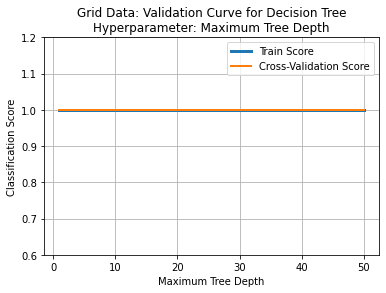

In [300]:
# decision tree: validation curve for maximum tree depth
from sklearn.model_selection import validation_curve

depth_range = np.arange(51)
train_scores, test_scores = validation_curve(DTclassifier, X_train2, y_train2, param_name='max_depth', param_range=depth_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(depth_range, np.mean(train_scores, axis=1), label='Train Score', linewidth=3)
plt.plot(depth_range, np.mean(test_scores, axis=1), label='Cross-Validation Score', linewidth=2)
plt.ylim(0.6,1.2)
plt.title('Grid Data: Validation Curve for Decision Tree\nHyperparameter: Maximum Tree Depth')
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 0, 'Minimum Leaf Size')

Text(0, 0.5, 'Classification Score')

Text(0.5, 1.0, 'Grid Data: Validation Curve for Decision Tree Classifier\nHyperparameter:Minimum Leaf Size')

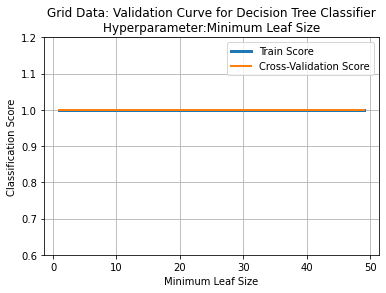

In [301]:
# decision tree: validation curve for min leaf size

# range of values to test
param_range = np.arange(1, 50)

# calculate train and validation scores
train_scores, test_scores = validation_curve(DTclassifier, X_train2, y_train2, param_name="min_samples_leaf", param_range=param_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label="Train Score", linewidth=3)
plt.plot(param_range, np.mean(test_scores, axis=1), label="Cross-Validation Score", linewidth=2)
plt.ylim(0.6,1.2)
plt.xlabel("Minimum Leaf Size")
plt.ylabel("Classification Score")
plt.title("Grid Data: Validation Curve for Decision Tree Classifier\nHyperparameter:Minimum Leaf Size")
plt.legend(loc="best")
plt.grid()
plt.show()



In [106]:

depth_range = np.arange(1,50)
parameters = {'max_depth' : depth_range}
DTclassifier = GridSearchCV(DTclassifier, param_grid=parameters, cv=5)
t0 = time.time()
DTclassifier.fit(X_train2, y_train2)
t1 = time.time()
train_time[0] = t1 - t0
print('Completed training in %f seconds' % train_time[0])

#best_clf_dt = DTclassifier
best_dt_params = DTclassifier.best_params_
print("Best parameters set for decision tree found on development set:")
print(best_dt_params)

t0 = time.time()
y_pred = DTclassifier.predict(X_val)
t1 = time.time()
test_time[0] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[0])
best_accuracy[0] = accuracy_score(y_val, y_pred)
print('Accuracy of decision tree is %.2f%%' % (best_accuracy[0] * 100))

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=0),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

Completed training in 10.880109 seconds
Best parameters set for decision tree found on development set:
{'max_depth': 1}
Inference time on test data: 0.000000 seconds
Accuracy of decision tree is 99.95%


In [124]:

min_leaf = np.arange(1,50)
parameters = {'min_samples_leaf' : min_leaf}
DTclassifier = GridSearchCV(DTclassifier, param_grid=parameters, cv=5)
t0 = time.time()
DTclassifier.fit(X_train2, y_train2)
t1 = time.time()
train_time[0] = t1 - t0
print('Completed training in %f seconds' % train_time[0])

#best_clf_dt = DTclassifier
best_dt_params = DTclassifier.best_params_
print("Best parameters set for decision tree found on development set:")
print(best_dt_params)

t0 = time.time()
y_pred = DTclassifier.predict(X_val)
t1 = time.time()
test_time[0] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[0])
best_accuracy[0] = accuracy_score(y_val, y_pred)
print('Accuracy of decision tree is %.2f%%' % (best_accuracy[0] * 100))

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=0),
             param_grid={'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

Completed training in 11.012379 seconds
Best parameters set for decision tree found on development set:
{'min_samples_leaf': 1}
Inference time on test data: 0.010044 seconds
Accuracy of decision tree is 99.95%


In [142]:
def TreeGridSearch(start_leaf_n, end_leaf_n, X_train, y_train):
    # parameters to search:
    # 20 values of max_depth from 1, 20
    param_grid = {'min_samples_leaf':np.linspace(start_leaf_n, end_leaf_n, 20).round().astype('int'), 'max_depth':np.arange(1,50)}
    DTclassifier = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5)
    t0 = time.time()
    DTclassifier.fit(X_train2, y_train2)
    t1 = time.time()
    train_time[0] = t1 - t0
    print('Completed training in %f seconds' % train_time[0])
    print("Per hyperparameter training, the best parameters are:", DTclassifier.best_params_)
    return DTclassifier.best_params_['max_depth'], DTclassifier.best_params_['min_samples_leaf']

# find best parameters 
# 20 values of min_samples leaf from 0.5% sample to 5% of training data
start_leaf_n = round(0.005*len(X_train2))
end_leaf_n = round(0.05*len(X_train2)) 
max_depth, min_samples_leaf = TreeGridSearch(start_leaf_n, end_leaf_n, X_train2, y_train2)

y_pred = DTclassifier.predict(X_val)

print('Accuracy of decision tree is:', accuracy_score(y_val, y_pred)*100, "%.")



Completed training in 108.661420 seconds
Per hyperparameter training, the best parameters are: {'max_depth': 1, 'min_samples_leaf': 32}
Accuracy of decision tree is: 100.0 %.


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Grid Data: Learning Curve for Decision Tree Model')

Text(0.5, 0, 'Fraction of Training Examples')

Text(0, 0.5, 'Classification Score')

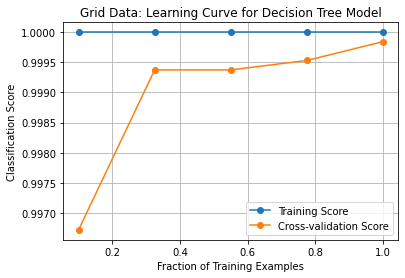

In [145]:
from sklearn.model_selection import learning_curve
# plot learning curve
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(DTclassifier, X_train2, y_train2, train_sizes=train_sizes, cv=5)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-Validation Score')
plt.title('Grid Data: Learning Curve for Decision Tree Model')
plt.xlabel('Fraction of Training Examples')
plt.ylabel("Classification Score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [153]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import timeit
def evaluate_test(classifier, X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    classifier.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = classifier.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    #cm = confusion_matrix(y_test,y_pred)

    print("Evaluation Metrics for Test Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    #plt.figure()
    #plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    #plt.show()

In [154]:
# evaluate decision tree model on test dataset
DTclass_best = DecisionTreeClassifier(max_depth = 1, min_samples_leaf = 32, random_state = 0, criterion = 'entropy')
evaluate_test(DTclass_best, X_train2, X_test, y_train2, y_test)


Evaluation Metrics for Test Dataset
*****************************************************
Model Training Time (s):   0.03526
Model Prediction Time (s): 0.00052

F1 Score:  1.00
Accuracy:  1.00     AUC:       1.00
Precision: 1.00     Recall:    1.00
*****************************************************


In [171]:
### Boosting
# boosted decision tree before hyperparameter tuning
from sklearn.ensemble import GradientBoostingClassifier

GBclassifier = GradientBoostingClassifier(max_depth=1, n_estimators=1, random_state=0)
GBclassifier.fit(X_train2, y_train2)
y_train_pred = GBclassifier.predict(X_train2)
GB_accuracy = accuracy_score(y_train2, y_train_pred)
print("The accuracy of the Boosted decision tree prior to hyperparameter tuning is", GB_accuracy*100, "%.")



GradientBoostingClassifier(max_depth=1, n_estimators=1, random_state=0)

The accuracy of the Boosted decision tree prior to hyperparameter tuning is 64.11939365525863 %.


<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 1.0, 'Grid Data: Validation Curve for Boosted Decision Tree\nHyperparameter: Maximum Tree Depth')

Text(0.5, 0, 'Maximum Tree Depth')

Text(0, 0.5, 'Classification Score')

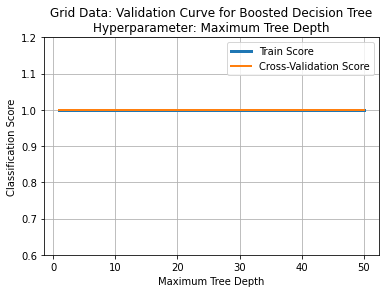

In [302]:
# Boost: validation curve for maximum tree depth

depth_range = np.arange(51)
train_scores, test_scores = validation_curve(GBclassifier, X_train2, y_train2, param_name='max_depth', param_range=depth_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(depth_range, np.mean(train_scores, axis=1), label='Train Score', linewidth=3)
plt.plot(depth_range, np.mean(test_scores, axis=1), label='Cross-Validation Score', linewidth=2)
plt.ylim(0.6,1.2)
plt.title('Grid Data: Validation Curve for Boosted Decision Tree\nHyperparameter: Maximum Tree Depth')
plt.xlabel('Maximum Tree Depth') 
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 0, 'Minimum Leaf Size')

Text(0, 0.5, 'Classification Score')

Text(0.5, 1.0, 'Grid Data: Validation Curve for Boosted Decision Tree \nHyperparameter: Minimum Leaf Size')

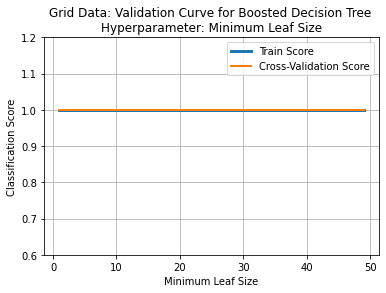

In [305]:
# BOOSTED decision tree: validation curve for min leaf size

# range of values to test
param_range = np.arange(1, 50)

# calculate train and validation scores
train_scores, test_scores = validation_curve(GBclassifier, X_train2, y_train2, param_name="min_samples_leaf", param_range=param_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label="Train Score", linewidth=3)
plt.plot(param_range, np.mean(test_scores, axis=1), label="Cross-Validation Score", linewidth=2)
plt.ylim(0.6,1.2)
plt.xlabel("Minimum Leaf Size")
plt.ylabel("Classification Score")
plt.title("Grid Data: Validation Curve for Boosted Decision Tree \nHyperparameter: Minimum Leaf Size")
plt.legend(loc="best")
plt.grid()
plt.show()



<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 1.0, 'Grid Data: Validation Curve for Boosted Decision Tree\nHyperparameter: Number of Weak Learners')

Text(0.5, 0, 'Number of Weak Learners')

Text(0, 0.5, 'Classification Score')

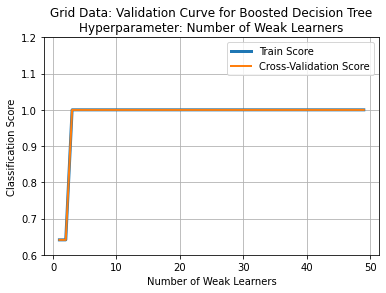

In [304]:
# Boost: validation curve for number of weak learners

param_range = np.arange(1, 50)
train_scores, test_scores = validation_curve(GBclassifier, X_train2, y_train2, param_name='n_estimators', param_range=param_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train Score', linewidth=3)
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-Validation Score', linewidth=2)
plt.ylim(0.6,1.2)
plt.title('Grid Data: Validation Curve for Boosted Decision Tree\nHyperparameter: Number of Weak Learners')
plt.xlabel('Number of Weak Learners') 
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [166]:
def TreeGridSearch(X_train, y_train):

    #    param_grid = {'min_samples_leaf':np.linspace(start_leaf_n, end_leaf_n, 10).round().astype('int'), 'max_depth':np.arange(1,20), 'n_estimators': np.linspace(10,50,2).round().astype('int')}
    param_grid = {'max_depth':np.arange(1,20), 'n_estimators': np.linspace(10,50,2).round().astype('int')}
    GBclassifier = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, cv=5)
    t0 = time.time()
    GBclassifier.fit(X_train2, y_train2)
    t1 = time.time()
    train_time[0] = t1 - t0
    print('Completed training in %f seconds' % train_time[0])
    print("Per hyperparameter training, the best parameters are:", GBclassifier.best_params_)
#    return GBclassifier.best_params_['max_depth'], GBclassifier.best_params_['min_samples_leaf'], GBclassifier.best_params_['n_estimators']
    return GBclassifier.best_params_['max_depth'], GBclassifier.best_params_['n_estimators']

# find best parameters 
#start_leaf_n = round(0.005*len(X_train2))
#end_leaf_n = round(0.05*len(X_train2)) 
#max_depth, min_samples_leaf, n_estimators = TreeGridSearch(start_leaf_n, end_leaf_n, X_train2, y_train2)
max_depth, n_estimators = TreeGridSearch(X_train2, y_train2)

y_pred = GBclassifier.predict(X_val)

print('Accuracy of boosted decision tree is:', accuracy_score(y_val, y_pred)*100, "%.")



Completed training in 65.849874 seconds
Per hyperparameter training, the best parameters are: {'max_depth': 1, 'n_estimators': 10}
Accuracy of boosted decision tree is: 100.0 %.


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Grid Data: Learning Curve for Boosted Decision Tree Model')

Text(0.5, 0, 'Fraction of Training Examples')

Text(0, 0.5, 'Classification Score')

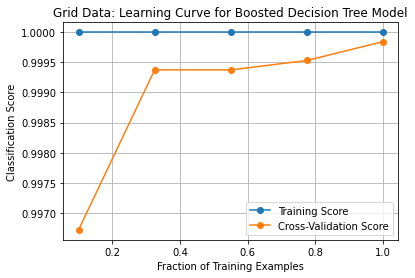

In [167]:
# plot learning curve for boosted decision tree
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(GBclassifier, X_train2, y_train2, train_sizes=train_sizes, cv=5)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-Validation Score')
plt.title('Grid Data: Learning Curve for Boosted Decision Tree Model')
plt.xlabel('Fraction of Training Examples')
plt.ylabel("Classification Score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [169]:
# evaluate boosted decision tree model on test dataset
GBclass_best = GradientBoostingClassifier(max_depth = 1, n_estimators = 10, random_state = 0)
evaluate_test(GBclass_best, X_train2, X_test, y_train2, y_test)


Evaluation Metrics for Test Dataset
*****************************************************
Model Training Time (s):   0.10794
Model Prediction Time (s): 0.00928

F1 Score:  1.00
Accuracy:  1.00     AUC:       1.00
Precision: 1.00     Recall:    1.00
*****************************************************


In [306]:
### k - Nearest Neighbors (kNN)
from sklearn.neighbors import KNeighborsClassifier as kNN

# kNN before hyperparameter tuning 
kNNclassifier = kNN()
kNNclassifier.fit(X_train2, y_train2)
y_train_pred = kNNclassifier.predict(X_train2)
kNN_accuracy = accuracy_score(y_train2, y_train_pred)
print("The accuracy of k-Nearest Neighbors model prior to hyperparameter tuning is", kNN_accuracy*100, "%.")



KNeighborsClassifier()

The accuracy of k-Nearest Neighbors model prior to hyperparameter tuning is 96.20253164556962 %.


<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 1.0, 'Grid Data: Validation Curve for kNN\nHyperparameter: Number of Neighbors')

Text(0.5, 0, 'Number of Neighbors')

Text(0, 0.5, 'Classification Score')

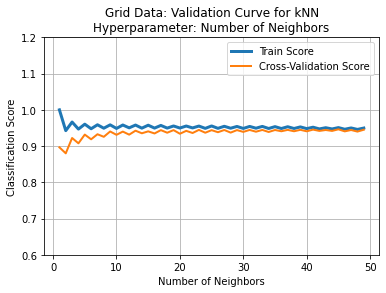

In [307]:
# kNN: validation curve for number of neighbors

param_range = np.arange(1,50)
train_scores, test_scores = validation_curve(kNNclassifier, X_train2, y_train2, param_name='n_neighbors', param_range=param_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train Score', linewidth=3)
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-Validation Score', linewidth=2)
plt.ylim(0.6,1.2)
plt.title('Grid Data: Validation Curve for kNN\nHyperparameter: Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 1.0, 'Grid Data: Validation Curve for kNN\nHyperparameter: Leaf Size')

Text(0.5, 0, 'Leaf Size')

Text(0, 0.5, 'Classification Score')

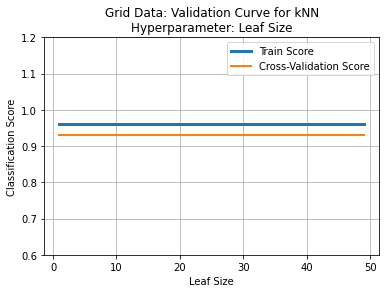

In [308]:
# kNN: validation curve for leaf size 

param_range = np.arange(1,50)
train_scores, test_scores = validation_curve(kNNclassifier, X_train2, y_train2, param_name='leaf_size', param_range=param_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train Score', linewidth=3)
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-Validation Score', linewidth=2)
plt.ylim(0.6,1.2)
plt.title('Grid Data: Validation Curve for kNN\nHyperparameter: Leaf Size')
plt.xlabel('Leaf Size')
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [179]:
def TreeGridSearch(X_train, y_train):
    # parameters to search:
    param_grid = {'n_neighbors':np.arange(1,20), 'leaf_size': np.arange(1,20)}
    kNNclassifier = GridSearchCV(estimator=kNN(), param_grid=param_grid, cv=5)
    t0 = time.time()
    kNNclassifier.fit(X_train2, y_train2)
    t1 = time.time()
    train_time[0] = t1 - t0
    print('Completed training in %f seconds' % train_time[0])
    print("Per hyperparameter training, the best parameters are:", kNNclassifier.best_params_)
    return kNNclassifier.best_params_['n_neighbors'], kNNclassifier.best_params_['leaf_size']

# find best parameters 
n_neighbors, leaf_size = TreeGridSearch(X_train2, y_train2)

y_pred = kNNclassifier.predict(X_val)

print('Accuracy of kNN model is:', accuracy_score(y_val, y_pred)*100, "%.")



Completed training in 780.215836 seconds
Per hyperparameter training, the best parameters are: {'leaf_size': 1, 'n_neighbors': 17}
Accuracy of kNN model is: 93.0 %.


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Grid Data: Learning Curve for kNN Model')

Text(0.5, 0, 'Fraction of Training Examples')

Text(0, 0.5, 'Classification Score')

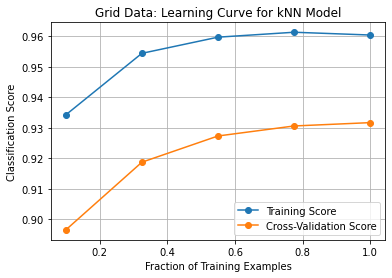

In [180]:
# plot learning curve for kNN
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(kNNclassifier, X_train2, y_train2, train_sizes=train_sizes, cv=5)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-Validation Score')
plt.title('Grid Data: Learning Curve for kNN Model')
plt.xlabel('Fraction of Training Examples')
plt.ylabel("Classification Score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [181]:
# evaluate decision tree model on test dataset
kNNclass_best = kNN(n_neighbors = 1, leaf_size = 17)
evaluate_test(kNNclass_best, X_train2, X_test, y_train2, y_test)


Evaluation Metrics for Test Dataset
*****************************************************
Model Training Time (s):   0.03988
Model Prediction Time (s): 0.64210

F1 Score:  0.86
Accuracy:  0.90     AUC:       0.89
Precision: 0.88     Recall:    0.83
*****************************************************


In [346]:
### Support Vector Machines (SVM)
from sklearn.svm import SVC

# SVM before hyperparameter tuning
SVM = SVC(random_state=0)
SVM.fit(X_train2, y_train2)
y_train_pred = SVM.predict(X_train2)
SVM_accuracy = accuracy_score(y_train2, y_train_pred)
print('The accuracy of SVM prior to hyperparameter training is', SVM_accuracy*100, "%.")


SVC(random_state=0)

The accuracy of SVM prior to hyperparameter training is 99.34364744491326 %.


In [350]:
kernel_labels = ['linear', 'poly', 'rbf', 'sigmoid']
train_scores, val_scores = [], []

for i, kernel in enumerate(kernel_labels):
    # Create and train SVM model
    SVM = SVC(kernel=kernel, random_state=0)
    SVM.fit(X_train2, y_train2)

    # Predictions
    y_train_pred = SVM.predict(X_train2)
    y_val_pred = SVM.predict(X_val)  # Assuming you have a separate validation set

    # Calculate accuracy scores
    train_accuracy = accuracy_score(y_train2, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    train_scores.append(train_accuracy)
    val_scores.append(val_accuracy)

    print(f'Kernel: {kernel}')
    print(f'Training Accuracy: {train_accuracy:.2f}')
    print(f'Validation Accuracy: {val_accuracy:.2f}\n')

SVC(kernel='linear', random_state=0)

Kernel: linear
Training Accuracy: 1.00
Validation Accuracy: 0.99



SVC(kernel='poly', random_state=0)

Kernel: poly
Training Accuracy: 0.98
Validation Accuracy: 0.96



SVC(random_state=0)

Kernel: rbf
Training Accuracy: 0.99
Validation Accuracy: 0.99



SVC(kernel='sigmoid', random_state=0)

Kernel: sigmoid
Training Accuracy: 0.95
Validation Accuracy: 0.95



In [ ]:
def val_kernel(X_train, y_train, title):
    kernel_labels = ['linear', 'poly', 'rbf', 'sigmoid']
    for i in kernel_labels:
        SVM = SVC(kernel = i, random_state=0)
        SVM.fit(X_train, y_train)
        y_pred = SVM.predict(X_train)
        

<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 1.0, 'Grid Data: Validation Curve for SVM\nHyperparameter: C')

Text(0.5, 0, 'C Value')

Text(0, 0.5, 'Classification Score')

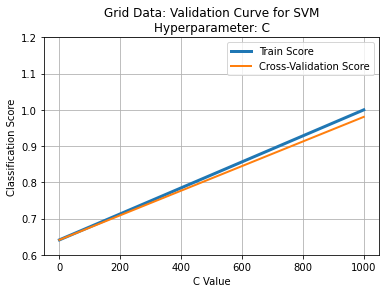

In [311]:
# decision tree: validation curve for C parameter
param_range = np.logspace(-3,3,2)
train_scores, test_scores = validation_curve(SVM, X_train2, y_train2, param_name='C', param_range=param_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train Score', linewidth=3)
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-Validation Score', linewidth=2)
plt.ylim(0.6,1.2)
plt.title('Grid Data: Validation Curve for SVM\nHyperparameter: C')
plt.xlabel('C Value')
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [201]:
# find best parameters of SVM and training time
def TreeGridSearch(X_train, y_train):
    param_grid = {'kernel':kernel_labels, 'C':np.logspace(-3,3,2)}
    SVM = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5)
    t0 = time.time()
    SVM.fit(X_train2, y_train2)
    t1 = time.time()
    train_time[0] = t1 - t0
    print('Completed training in %f seconds' % train_time[0])
    print("Per hyperparameter training, the best parameters are:", SVM.best_params_)
    return SVM.best_params_['kernel'], SVM.best_params_['C']

# find best parameters 
# 20 values of min_samples leaf from 0.5% sample to 5% of training data
#start_leaf_n = round(0.005*len(X_train2))
#end_leaf_n = round(0.05*len(X_train2)) 
kernel, C = TreeGridSearch(X_train2, y_train2)

y_pred = SVM.predict(X_val)

print('Accuracy of SVM is:', accuracy_score(y_val, y_pred)*100, "%.")



Completed training in 28.782900 seconds
Per hyperparameter training, the best parameters are: {'C': 1000.0, 'kernel': 'linear'}
Accuracy of SVM is: 98.625 %.


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Grid Data: Learning Curve for SVM')

Text(0.5, 0, 'Fraction of Training Examples')

Text(0, 0.5, 'Classification Score')

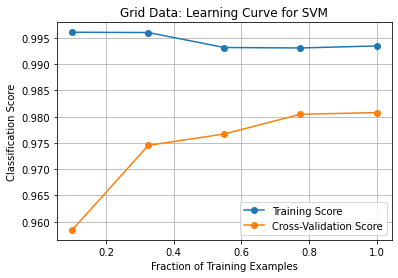

In [202]:
# plot learning curve for SVM
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(SVM, X_train2, y_train2, train_sizes=train_sizes, cv=5)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-Validation Score')
plt.title('Grid Data: Learning Curve for SVM')
plt.xlabel('Fraction of Training Examples')
plt.ylabel("Classification Score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [204]:
# evaluate SVM model on test dataset
SVM_best = SVC(kernel='linear', C=1000)
evaluate_test(SVM_best, X_train2, X_test, y_train2, y_test)


Evaluation Metrics for Test Dataset
*****************************************************
Model Training Time (s):   0.43999
Model Prediction Time (s): 0.01337

F1 Score:  1.00
Accuracy:  1.00     AUC:       1.00
Precision: 1.00     Recall:    1.00
*****************************************************


In [312]:
### NEURAL NETWORK - GRID DATASET
from sklearn.neural_network import MLPClassifier

# NN before hyperparameter tuning
NN = MLPClassifier(random_state=0)
NN.fit(X_train2, y_train2)
y_train_pred = NN.predict(X_train2)
NN_accuracy = accuracy_score(y_train2, y_train_pred)
print('The accuracy of the Decision Tree classifier prior to hyperparameter training is', NN_accuracy*100, '%.')

MLPClassifier(random_state=0)

The accuracy of the Decision Tree classifier prior to hyperparameter training is 100.0 %.


C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\li

<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 1.0, 'Grid Data: Validation Curve for Neural Network\nHyperparameter: Number of Layers')

Text(0.5, 0, 'Number of Layers')

Text(0, 0.5, 'Classification Score')

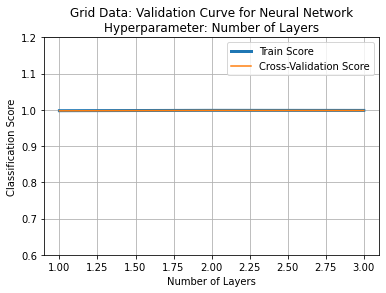

In [313]:
# NN: validation curve for number of layers
param_range = [1,2,3]
train_scores, test_scores = validation_curve(NN, X_train2, y_train2, param_name='hidden_layer_sizes', param_range=param_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train Score', linewidth=3)
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-Validation Score', linewidth=1.5)
plt.ylim(0.6,1.2)
plt.title('Grid Data: Validation Curve for Neural Network\nHyperparameter: Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 1.0, 'Grid Data: Validation Curve for Neural Network\nHyperparameter: Learning Rate')

Text(0.5, 0, 'Learning Rate')

Text(0, 0.5, 'Classification Score')

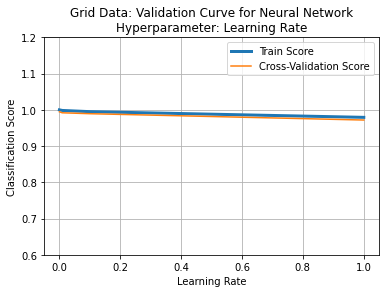

In [314]:
# NN: validation curve for learning rate
param_range = np.logspace(-3,0,4)
train_scores, test_scores = validation_curve(NN, X_train2, y_train2, param_name='learning_rate_init', param_range=param_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train Score', linewidth=3)
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-Validation Score', linewidth=1.5)
plt.ylim(0.6,1.2)
plt.title('Grid Data: Validation Curve for Neural Network\nHyperparameter: Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [214]:
# NN: find best parameters 
def TreeGridSearch(X_train, y_train):
    param_grid = {'hidden_layer_sizes':[1,2,3], 'learning_rate_init':np.logspace(-3,0,4)}
    NN = GridSearchCV(estimator=MLPClassifier(), param_grid=param_grid, cv=5)
    t0 = time.time()
    NN.fit(X_train2, y_train2)
    t1 = time.time()
    train_time[0] = t1 - t0
    print('Completed training in %f seconds' % train_time[0])
    print('Per hyperparameter training, the best parameters are:', NN.best_params_)
    return NN.best_params_['hidden_layer_sizes'], NN.best_params_['learning_rate_init']

hidden_layer_sizes, learning_rate_init = TreeGridSearch(X_train2, y_train2)
y_pred = NN.predict(X_val)

print('Accuracy of the Neural Network is:', accuracy_score(y_val, y_pred)*100, '%.')

C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\li

Completed training in 73.613286 seconds
Per hyperparameter training, the best parameters are: {'hidden_layer_sizes': 1, 'learning_rate_init': 0.01}
Accuracy of the Neural Network is: 99.75 %.


C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\li

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Grid Data: Learning Curve for Neural Network')

Text(0.5, 0, 'Fraction of Training Examples')

Text(0, 0.5, 'Classification Score')

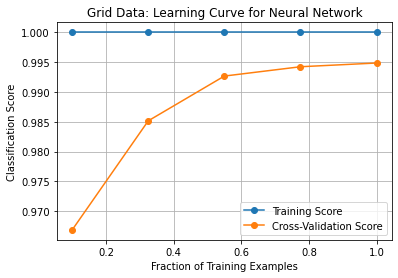

In [215]:
# NN: plot learning curve
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(NN, X_train2, y_train2, train_sizes=train_sizes, cv=5)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-Validation Score')
plt.title('Grid Data: Learning Curve for Neural Network')
plt.xlabel('Fraction of Training Examples')
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [216]:
# evaluate decision tree model on test dataset
NN_best = MLPClassifier(hidden_layer_sizes = 1, learning_rate_init = 0.01, random_state = 0)
evaluate_test(NN_best, X_train2, X_test, y_train2, y_test)


Evaluation Metrics for Test Dataset
*****************************************************
Model Training Time (s):   1.73237
Model Prediction Time (s): 0.00539

F1 Score:  1.00
Accuracy:  1.00     AUC:       1.00
Precision: 1.00     Recall:    0.99
*****************************************************


In [ ]:
# buffer zone

In [351]:
### WISCONSIN BREAST CANCER DATASET 
from sklearn.datasets import load_breast_cancer
bc = load_breast_cancer()
bc.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [352]:
wisc_features = pd.DataFrame(bc.data, columns = bc.feature_names)
wisc_target = pd.DataFrame(bc.target, columns=['target'])
wisc_target['target'].value_counts()
# form final dataset
wisc = pd.concat([wisc_features, wisc_target], axis=1)
wisc.head()

1    357
0    212
Name: target, dtype: int64

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [353]:
### preprocess wisc data

# find missing values
print("Missing Values:\n", wisc.isna().sum())

# determine type of variable
print("\nType of Each Variable:", wisc.dtypes)

# number of rows and columns
print("\nBreast Cancer dataset has", len(wisc), "rows and", len(wisc.columns), "columns.")


Missing Values:
 mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

Type of Each Variable: mean radius                float64
mean texture

In [354]:
### split wisconsin dataset into test and train set
X_w = wisc.iloc[:,:-1]
y_w = wisc['target']

# scale 
X_w = scaler.fit_transform(X_w)

# split data into test and train tests
X_trainW, X_testW, y_trainW, y_testW = train_test_split(X_w, y_w, test_size=0.2, random_state=0)

# balance of dataset
print("\nFraction of positive examples: %.2f%%" % (y_w[y_w == 1].shape[0]/y_w.shape[0]**100.0))

# split train set into train and validation set
X_train2W, X_valW, y_train2W, y_valW = train_test_split(X_trainW, y_trainW, test_size=0.2, random_state=0)

# data structures to store values later 
wisc_numclassifiers = 5
best_accuracy = np.zeros(wisc_numclassifiers)
train_time = np.zeros(wisc_numclassifiers)
test_time = np.zeros(wisc_numclassifiers)



Fraction of positive examples: 0.00%


In [355]:
### WISC decision tree before hyperparameter tuning
from sklearn import tree
DTclassifier = tree.DecisionTreeClassifier(random_state=0)
DTclassifier.fit(X_train2W, y_train2W)
y_train_pred = DTclassifier.predict(X_train2W)
DT_accuracy = accuracy_score(y_train2W, y_train_pred)
print('The accuracy of the Decision Tree classifier prior to hyperparameter training is', DT_accuracy*100, "%.")

DecisionTreeClassifier(random_state=0)

The accuracy of the Decision Tree classifier prior to hyperparameter training is 100.0 %.


<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 1.0, 'Cancer Data: Validation Curve for Decision Tree\nHyperparameter: Maximum Tree Depth')

Text(0.5, 0, 'Maximum Tree Depth')

Text(0, 0.5, 'Classification Score')

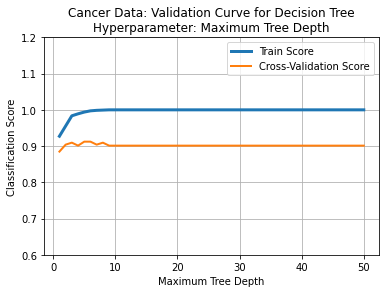

In [321]:
# WISCONSIN decision tree: validation curve for maximum tree depth
depth_range = np.arange(51)
train_scores, test_scores = validation_curve(DTclassifier, X_train2W, y_train2W, param_name='max_depth', param_range=depth_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(depth_range, np.mean(train_scores, axis=1), label='Train Score', linewidth=3)
plt.plot(depth_range, np.mean(test_scores, axis=1), label='Cross-Validation Score', linewidth=2)
plt.ylim(0.6,1.2)
plt.title('Cancer Data: Validation Curve for Decision Tree\nHyperparameter: Maximum Tree Depth')
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 0, 'Minimum Leaf Size')

Text(0, 0.5, 'Classification Score')

Text(0.5, 1.0, 'Cancer Data: Validation Curve for Decision Tree Classifier\nHyperparameter:Minimum Leaf Size')

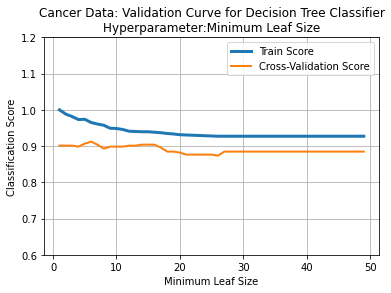

In [322]:
# WISCONSIN decision tree: validation curve for min leaf size

# range of values to test
param_range = np.arange(1, 50)

# calculate train and validation scores
train_scores, test_scores = validation_curve(DTclassifier, X_train2W, y_train2W, param_name="min_samples_leaf", param_range=param_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label="Train Score", linewidth=3)
plt.plot(param_range, np.mean(test_scores, axis=1), label="Cross-Validation Score", linewidth=2)
plt.ylim(0.6,1.2)
plt.xlabel("Minimum Leaf Size")
plt.ylabel("Classification Score")
plt.title("Cancer Data: Validation Curve for Decision Tree Classifier\nHyperparameter:Minimum Leaf Size")
plt.legend(loc="best")
plt.grid()
plt.show()



In [264]:
def TreeGridSearch(start_leaf_n, end_leaf_n, X_train, y_train):
    param_grid = {'min_samples_leaf':np.linspace(start_leaf_n, end_leaf_n, 20).round().astype('int'), 'max_depth':np.arange(1,50)}
    DTclassifier = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5)
    t0 = time.time()
    DTclassifier.fit(X_train2W, y_train2W)
    t1 = time.time()
    train_time[0] = t1 - t0
    print('Completed training in %f seconds' % train_time[0])
    print("Per hyperparameter training, the best parameters are:", DTclassifier.best_params_)
    return DTclassifier.best_params_['max_depth'], DTclassifier.best_params_['min_samples_leaf']

# find best parameters 
# 20 values of min_samples leaf from 0.5% sample to 5% of training data
start_leaf_n = round(0.005*len(X_train2W))
end_leaf_n = round(0.05*len(X_train2W)) 
max_depth, min_samples_leaf = TreeGridSearch(start_leaf_n, end_leaf_n, X_train2W, y_train2W)

y_pred = DTclassifier.predict(X_valW)

print('Accuracy of decision tree is:', accuracy_score(y_valW, y_pred)*100, "%.")



Completed training in 47.717063 seconds
Per hyperparameter training, the best parameters are: {'max_depth': 10, 'min_samples_leaf': 6}
Accuracy of decision tree is: 89.01098901098901 %.


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Cancer Data: Learning Curve for Decision Tree Model')

Text(0.5, 0, 'Fraction of Training Examples')

Text(0, 0.5, 'Classification Score')

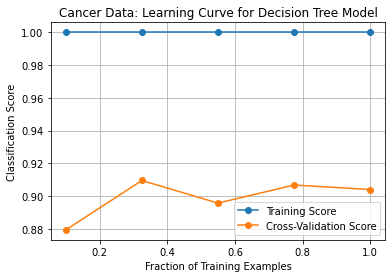

In [266]:
# WISCONSIN: decision tree - plot learning curve
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(DTclassifier, X_train2W, y_train2W, train_sizes=train_sizes, cv=5)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-Validation Score')
plt.title('Cancer Data: Learning Curve for Decision Tree Model')
plt.xlabel('Fraction of Training Examples')
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [267]:
# WISCONSIN -evaluate decision tree model on test dataset
DTclass_best = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 6, random_state = 0, criterion = 'entropy')
evaluate_test(DTclass_best, X_train2W, X_testW, y_train2W, y_testW)


Evaluation Metrics for Test Dataset
*****************************************************
Model Training Time (s):   0.01356
Model Prediction Time (s): 0.00056

F1 Score:  0.97
Accuracy:  0.96     AUC:       0.96
Precision: 0.97     Recall:    0.97
*****************************************************


In [323]:
### Boosting - wisconsin
# boosted decision tree before hyperparameter tuning
GBclassifier = GradientBoostingClassifier(random_state=0)
GBclassifier.fit(X_train2W, y_train2W)
y_train_pred = GBclassifier.predict(X_train2W)
GB_accuracy = accuracy_score(y_train2W, y_train_pred)
print("The accuracy of the Boosted decision tree prior to hyperparameter tuning is", GB_accuracy*100, "%.")



GradientBoostingClassifier(random_state=0)

The accuracy of the Boosted decision tree prior to hyperparameter tuning is 100.0 %.


<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 1.0, 'Cancer Data: Validation Curve for Boosted Decision Tree\nHyperparameter: Maximum Tree Depth')

Text(0.5, 0, 'Maximum Tree Depth')

Text(0, 0.5, 'Classification Score')

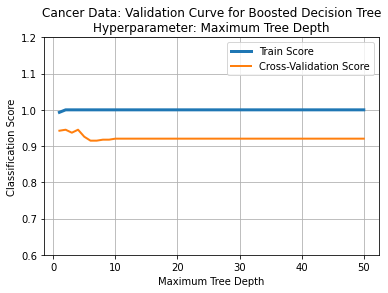

In [324]:
# Boost:  WISCONSIN validation curve for maximum tree depth 

depth_range = np.arange(51)
train_scores, test_scores = validation_curve(GBclassifier, X_train2W, y_train2W, param_name='max_depth', param_range=depth_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(depth_range, np.mean(train_scores, axis=1), label='Train Score', linewidth=3)
plt.plot(depth_range, np.mean(test_scores, axis=1), label='Cross-Validation Score', linewidth=2)
plt.ylim(0.6,1.2)
plt.title('Cancer Data: Validation Curve for Boosted Decision Tree\nHyperparameter: Maximum Tree Depth')
plt.xlabel('Maximum Tree Depth') 
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 0, 'Minimum Leaf Size')

Text(0, 0.5, 'Classification Score')

Text(0.5, 1.0, 'Cancer Data: Validation Curve for Boosted Decision Tree \nHyperparameter: Minimum Leaf Size')

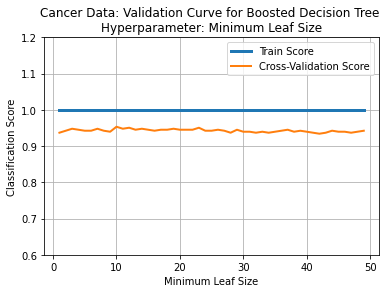

In [325]:
# BOOSTED decision tree: WISCONSIN validation curve for min leaf size

# range of values to test
param_range = np.arange(1, 50)

# calculate train and validation scores
train_scores, test_scores = validation_curve(GBclassifier, X_train2W, y_train2W, param_name="min_samples_leaf", param_range=param_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label="Train Score", linewidth=3)
plt.plot(param_range, np.mean(test_scores, axis=1), label="Cross-Validation Score", linewidth=2)
plt.ylim(0.6,1.2)
plt.xlabel("Minimum Leaf Size")
plt.ylabel("Classification Score")
plt.title("Cancer Data: Validation Curve for Boosted Decision Tree \nHyperparameter: Minimum Leaf Size")
plt.legend(loc="best")
plt.grid()
plt.show()



<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 1.0, 'Cancer Data: Validation Curve for Boosted Decision Tree\nHyperparameter: Number of Weak Learners')

Text(0.5, 0, 'Number of Weak Learners')

Text(0, 0.5, 'Classification Score')

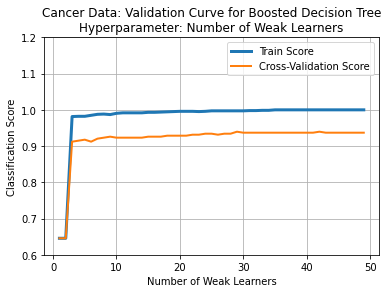

In [326]:
# Boost: WISCONSIN validation curve for number of weak learners

param_range = np.arange(1, 50)
train_scores, test_scores = validation_curve(GBclassifier, X_train2W, y_train2W, param_name='n_estimators', param_range=param_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train Score', linewidth=3)
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-Validation Score', linewidth=2)
plt.ylim(0.6,1.2)
plt.title('Cancer Data: Validation Curve for Boosted Decision Tree\nHyperparameter: Number of Weak Learners')
plt.xlabel('Number of Weak Learners') 
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [273]:
# WISCONSIN - find best parameters
def TreeGridSearch(X_train, y_train):
    param_grid = {'max_depth':np.arange(1,20), 'n_estimators': np.linspace(10,50,2).round().astype('int')}
    GBclassifier = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, cv=5)
    t0 = time.time()
    GBclassifier.fit(X_train2W, y_train2W)
    t1 = time.time()
    train_time[0] = t1 - t0
    print('Completed training in %f seconds' % train_time[0])
    print("Per hyperparameter training, the best parameters are:", GBclassifier.best_params_)
    return GBclassifier.best_params_['max_depth'], GBclassifier.best_params_['n_estimators']

max_depth, n_estimators = TreeGridSearch(X_train2W, y_train2W)

y_pred = GBclassifier.predict(X_valW)

print('Accuracy of boosted decision tree is:', accuracy_score(y_valW, y_pred)*100, "%.")



Completed training in 44.023244 seconds
Per hyperparameter training, the best parameters are: {'max_depth': 1, 'n_estimators': 50}
Accuracy of boosted decision tree is: 92.3076923076923 %.


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Cancer Data: Learning Curve for Boosted Decision Tree Model')

Text(0.5, 0, 'Fraction of Training Examples')

Text(0, 0.5, 'Classification Score')

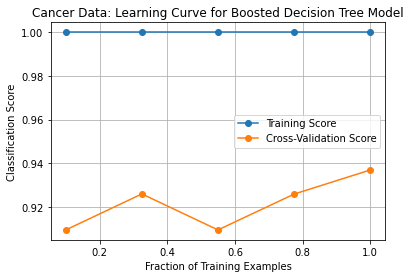

In [274]:
# WISCONSIN - plot learning curve for boosted decision tree
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(GBclassifier, X_train2W, y_train2W, train_sizes=train_sizes, cv=5)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-Validation Score')
plt.title('Cancer Data: Learning Curve for Boosted Decision Tree Model')
plt.xlabel('Fraction of Training Examples')
plt.ylabel("Classification Score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [275]:
# evaluate boosted decision tree model on test dataset
GBclass_best = GradientBoostingClassifier(max_depth = 1, n_estimators = 50, random_state = 0)
evaluate_test(GBclass_best, X_train2W, X_testW, y_train2W, y_testW)


Evaluation Metrics for Test Dataset
*****************************************************
Model Training Time (s):   0.13636
Model Prediction Time (s): 0.00103

F1 Score:  0.98
Accuracy:  0.97     AUC:       0.97
Precision: 0.96     Recall:    1.00
*****************************************************


In [327]:
### k - Nearest Neighbors (kNN) Wisconsin

# kNN before hyperparameter tuning 
kNNclassifier = kNN()
kNNclassifier.fit(X_train2W, y_train2W)
y_train_pred = kNNclassifier.predict(X_train2W)
kNN_accuracy = accuracy_score(y_train2W, y_train_pred)
print("The accuracy of k-Nearest Neighbors model prior to hyperparameter tuning is", kNN_accuracy*100, "%.")



KNeighborsClassifier()

The accuracy of k-Nearest Neighbors model prior to hyperparameter tuning is 98.07692307692307 %.


<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 1.0, 'Cancer Data: Validation Curve for kNN\nHyperparameter: Number of Neighbors')

Text(0.5, 0, 'Number of Neighbors')

Text(0, 0.5, 'Classification Score')

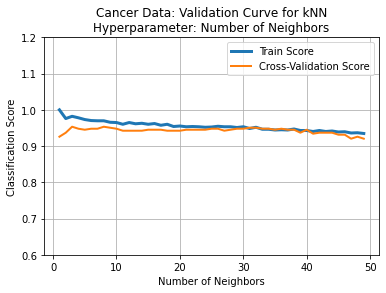

In [328]:
# kNN: validation curve for number of neighbors - WISCONSIN

param_range = np.arange(1,50)
train_scores, test_scores = validation_curve(kNNclassifier, X_train2W, y_train2W, param_name='n_neighbors', param_range=param_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train Score', linewidth=3)
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-Validation Score', linewidth=2)
plt.ylim(0.6,1.2)
plt.title('Cancer Data: Validation Curve for kNN\nHyperparameter: Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 1.0, 'Cancer Data: Validation Curve for kNN\nHyperparameter: Leaf Size')

Text(0.5, 0, 'Leaf Size')

Text(0, 0.5, 'Classification Score')

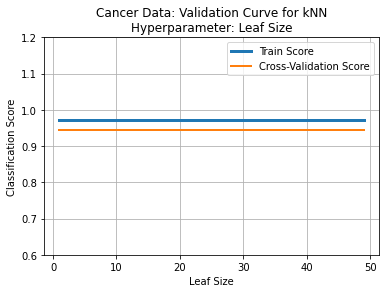

In [329]:
# kNN: validation curve for leaf size  - WISCONSIN

param_range = np.arange(1,50)
train_scores, test_scores = validation_curve(kNNclassifier, X_train2W, y_train2W, param_name='leaf_size', param_range=param_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train Score', linewidth=3)
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-Validation Score', linewidth=2)
plt.ylim(0.6,1.2)
plt.title('Cancer Data: Validation Curve for kNN\nHyperparameter: Leaf Size')
plt.xlabel('Leaf Size')
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [279]:
# find best parameters - WISCONSIN
def TreeGridSearch(X_train, y_train):
    # parameters to search:
    param_grid = {'n_neighbors':np.arange(1,20), 'leaf_size': np.arange(1,20)}
    kNNclassifier = GridSearchCV(estimator=kNN(), param_grid=param_grid, cv=5)
    t0 = time.time()
    kNNclassifier.fit(X_train2W, y_train2W)
    t1 = time.time()
    train_time[0] = t1 - t0
    print('Completed training in %f seconds' % train_time[0])
    print("Per hyperparameter training, the best parameters are:", kNNclassifier.best_params_)
    return kNNclassifier.best_params_['n_neighbors'], kNNclassifier.best_params_['leaf_size']

# find best parameters 
n_neighbors, leaf_size = TreeGridSearch(X_train2W, y_train2W)

y_pred = kNNclassifier.predict(X_valW)

print('Accuracy of kNN model is:', accuracy_score(y_valW, y_pred)*100, "%.")



Completed training in 20.574016 seconds
Per hyperparameter training, the best parameters are: {'leaf_size': 1, 'n_neighbors': 3}
Accuracy of kNN model is: 97.8021978021978 %.


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Cancer Data: Learning Curve for kNN Model')

Text(0.5, 0, 'Fraction of Training Examples')

Text(0, 0.5, 'Classification Score')

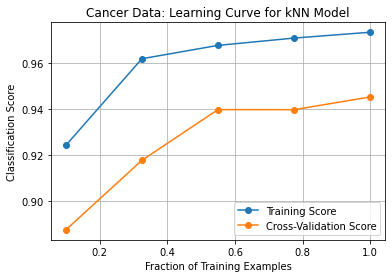

In [280]:
# plot learning curve for kNN - WISCONSIN
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(kNNclassifier, X_train2W, y_train2W, train_sizes=train_sizes, cv=5)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-Validation Score')
plt.title('Cancer Data: Learning Curve for kNN Model')
plt.xlabel('Fraction of Training Examples')
plt.ylabel("Classification Score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [281]:
# evaluate decision tree model on test dataset - wisconsin

# replace with best values
kNNclass_best = kNN(n_neighbors = 3, leaf_size = 1)
evaluate_test(kNNclass_best, X_train2W, X_testW, y_train2W, y_testW)


Evaluation Metrics for Test Dataset
*****************************************************
Model Training Time (s):   0.00182
Model Prediction Time (s): 0.01503

F1 Score:  0.96
Accuracy:  0.96     AUC:       0.95
Precision: 0.93     Recall:    1.00
*****************************************************


In [330]:
### Support Vector Machines (SVM) - wisconsin
# SVM before hyperparameter tuning
SVM = SVC(random_state=0)
SVM.fit(X_train2W, y_train2W)
y_train_pred = SVM.predict(X_train2W)
SVM_accuracy = accuracy_score(y_train2W, y_train_pred)
print('The accuracy of SVM prior to hyperparameter training is', SVM_accuracy*100, "%.")


SVC(random_state=0)

The accuracy of SVM prior to hyperparameter training is 98.62637362637363 %.


In [356]:
kernel_labels = ['linear', 'poly', 'rbf', 'sigmoid']
train_scores, val_scores = [], []

for i, kernel in enumerate(kernel_labels):
    # Create and train SVM model
    SVM = SVC(kernel=kernel, random_state=0)
    SVM.fit(X_train2W, y_train2W)

    # Predictions
    y_train_pred = SVM.predict(X_train2W)
    y_val_pred = SVM.predict(X_valW)  
    
    # Calculate accuracy scores
    train_accuracy = accuracy_score(y_train2W, y_train_pred)
    val_accuracy = accuracy_score(y_valW, y_val_pred)

    train_scores.append(train_accuracy)
    val_scores.append(val_accuracy)

    print(f'Kernel: {kernel}')
    print(f'Training Accuracy: {train_accuracy:.2f}')
    print(f'Validation Accuracy: {val_accuracy:.2f}\n')

SVC(kernel='linear', random_state=0)

Kernel: linear
Training Accuracy: 0.99
Validation Accuracy: 0.96



SVC(kernel='poly', random_state=0)

Kernel: poly
Training Accuracy: 0.90
Validation Accuracy: 0.91



SVC(random_state=0)

Kernel: rbf
Training Accuracy: 0.99
Validation Accuracy: 0.98



SVC(kernel='sigmoid', random_state=0)

Kernel: sigmoid
Training Accuracy: 0.96
Validation Accuracy: 0.95



<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 1.0, 'Cancer Data: Validation Curve for SVM\nHyperparameter: C')

Text(0.5, 0, 'C Value')

Text(0, 0.5, 'Classification Score')

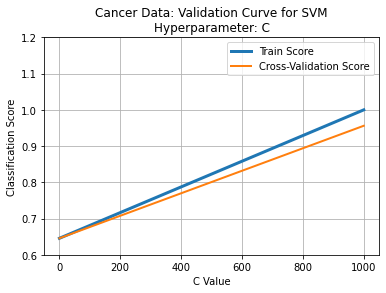

In [332]:
# decision tree: validation curve for C parameter - WISCONSIN
param_range = np.logspace(-3,3,2)
train_scores, test_scores = validation_curve(SVM, X_train2W, y_train2W, param_name='C', param_range=param_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train Score', linewidth=3)
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-Validation Score', linewidth=2)
plt.ylim(0.6,1.2)
plt.title('Cancer Data: Validation Curve for SVM\nHyperparameter: C')
plt.xlabel('C Value')
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [285]:
# find best parameters of SVM and training time - wisconsin
def TreeGridSearch(X_train, y_train):
    param_grid = {'kernel':kernel_labels, 'C':np.logspace(-3,3,2)}
    SVM = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5)
    t0 = time.time()
    SVM.fit(X_train2W, y_train2W)
    t1 = time.time()
    train_time[0] = t1 - t0
    print('Completed training in %f seconds' % train_time[0])
    print("Per hyperparameter training, the best parameters are:", SVM.best_params_)
    return SVM.best_params_['kernel'], SVM.best_params_['C']

# find best parameters 
kernel, C = TreeGridSearch(X_train2W, y_train2W)

y_pred = SVM.predict(X_valW)

print('Accuracy of SVM is:', accuracy_score(y_valW, y_pred)*100, "%.")



Completed training in 0.530343 seconds
Per hyperparameter training, the best parameters are: {'C': 1000.0, 'kernel': 'linear'}
Accuracy of SVM is: 97.8021978021978 %.


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Grid Data: Learning Curve for SVM')

Text(0.5, 0, 'Fraction of Training Examples')

Text(0, 0.5, 'Classification Score')

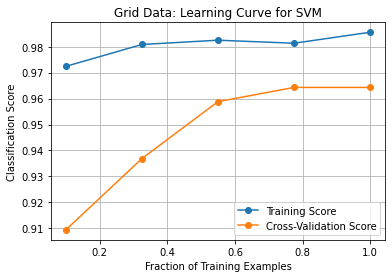

In [286]:
# plot learning curve for SVM
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(SVM, X_train2W, y_train2W, train_sizes=train_sizes, cv=5)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-Validation Score')
plt.title('Grid Data: Learning Curve for SVM')
plt.xlabel('Fraction of Training Examples')
plt.ylabel("Classification Score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [287]:
# evaluate SVM model on test dataset
SVM_best = SVC(kernel='linear', C=1000)
evaluate_test(SVM_best, X_train2W, X_testW, y_train2W, y_testW)


Evaluation Metrics for Test Dataset
*****************************************************
Model Training Time (s):   0.01314
Model Prediction Time (s): 0.00054

F1 Score:  0.97
Accuracy:  0.96     AUC:       0.97
Precision: 1.00     Recall:    0.94
*****************************************************


In [333]:
### NEURAL NETWORK - GRID DATASET - WISCONSIN
# NN before hyperparameter tuning
NN = MLPClassifier(random_state=0)
NN.fit(X_train2W, y_train2W)
y_train_pred = NN.predict(X_train2W)
NN_accuracy = accuracy_score(y_train2W, y_train_pred)
print('The accuracy of the Decision Tree classifier prior to hyperparameter training is', NN_accuracy*100, '%.')

C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=0)

The accuracy of the Decision Tree classifier prior to hyperparameter training is 99.17582417582418 %.


C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\li

<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 1.0, 'Cancer Data: Validation Curve for Neural Network\nHyperparameter: Number of Layers')

Text(0.5, 0, 'Number of Layers')

Text(0, 0.5, 'Classification Score')

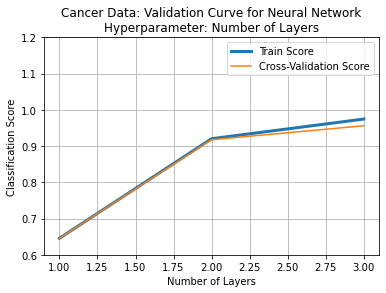

In [334]:
# NN: validation curve for number of layers - WISCONSIN
param_range = [1,2,3]
train_scores, test_scores = validation_curve(NN, X_train2W, y_train2W, param_name='hidden_layer_sizes', param_range=param_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train Score', linewidth=3)
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-Validation Score', linewidth=1.5)
plt.ylim(0.6,1.2)
plt.title('Cancer Data: Validation Curve for Neural Network\nHyperparameter: Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\li

<Figure size 432x288 with 0 Axes>

(0.6, 1.2)

Text(0.5, 1.0, 'Cancer Data: Validation Curve for Neural Network\nHyperparameter: Learning Rate')

Text(0.5, 0, 'Learning Rate')

Text(0, 0.5, 'Classification Score')

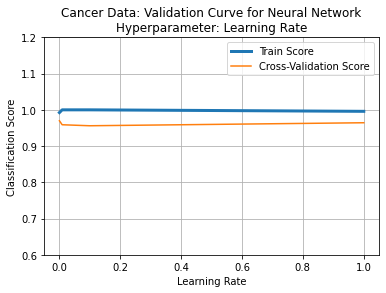

In [335]:
# NN: validation curve for learning rate - wisconsin
param_range = np.logspace(-3,0,4)
train_scores, test_scores = validation_curve(NN, X_train2W, y_train2W, param_name='learning_rate_init', param_range=param_range, cv=5)

# plot validation curve
plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train Score', linewidth=3)
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-Validation Score', linewidth=1.5)
plt.ylim(0.6,1.2)
plt.title('Cancer Data: Validation Curve for Neural Network\nHyperparameter: Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [291]:
# NN: find best parameters  - WISCONSIN
def TreeGridSearch(X_train, y_train):
    param_grid = {'hidden_layer_sizes':[1,2,3], 'learning_rate_init':np.logspace(-3,0,4)}
    NN = GridSearchCV(estimator=MLPClassifier(), param_grid=param_grid, cv=5)
    t0 = time.time()
    NN.fit(X_train2W, y_train2W)
    t1 = time.time()
    train_time[0] = t1 - t0
    print('Completed training in %f seconds' % train_time[0])
    print('Per hyperparameter training, the best parameters are:', NN.best_params_)
    return NN.best_params_['hidden_layer_sizes'], NN.best_params_['learning_rate_init']

hidden_layer_sizes, learning_rate_init = TreeGridSearch(X_train2W, y_train2W)
y_pred = NN.predict(X_valW)

print('Accuracy of the Neural Network is:', accuracy_score(y_valW, y_pred)*100, '%.')

C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\li

Completed training in 15.476465 seconds
Per hyperparameter training, the best parameters are: {'hidden_layer_sizes': 1, 'learning_rate_init': 0.01}
Accuracy of the Neural Network is: 97.8021978021978 %.


C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Amulya Cherian\anaconda3\li

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Cancer Data: Learning Curve for Neural Network')

Text(0.5, 0, 'Fraction of Training Examples')

Text(0, 0.5, 'Classification Score')

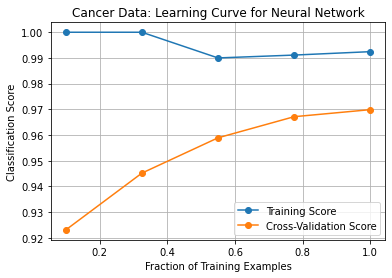

In [292]:
# NN: plot learning curve - WISCONSIN
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(NN, X_train2W, y_train2W, train_sizes=train_sizes, cv=5)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-Validation Score')
plt.title('Cancer Data: Learning Curve for Neural Network')
plt.xlabel('Fraction of Training Examples')
plt.ylabel('Classification Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [293]:
# evaluate decision tree model on test dataset - wisconsin
NN_best = MLPClassifier(hidden_layer_sizes = 1, learning_rate_init = 0.01, random_state = 0)
evaluate_test(NN_best, X_train2W, X_testW, y_train2W, y_testW)


Evaluation Metrics for Test Dataset
*****************************************************
Model Training Time (s):   0.31627
Model Prediction Time (s): 0.00073

F1 Score:  0.97
Accuracy:  0.96     AUC:       0.96
Precision: 0.97     Recall:    0.97
*****************************************************


C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
#GOO